In [1]:
import sys
sys.path.append('../')
import sportran as st
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from scipy.interpolate import CubicSpline, interp1d
def model_scalar(x, y):
    return CubicSpline(np.concatenate([-x[::-1], x[1:]]), np.concatenate([y[::-1], y[1:]]))

n = 2
def model_wishart_(x, y):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    y00, y01, y11 = y.reshape(3,l)
    yy = np.array([[y00, y01], [np.zeros_like(y01), y11]]).T
    # yy = np.einsum('tab,tbc->tac', np.transpose(yy, axes=(0,2,1)), yy)
    yy = np.concatenate([yy[::-1], yy[1:]])
    # return interp1d(xx, yy)) 
    return CubicSpline(xx, yy) #, bc_type = 'clamped')

import numpy as np
from scipy.interpolate import CubicSpline

def model_wishart(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    upper_triangle_indices = np.triu_indices(N)
    y_elements = y.reshape(len(upper_triangle_indices[0]), l)
    
    yy = np.zeros((l, N, N))
    for k, (i, j) in enumerate(zip(*upper_triangle_indices)):
        yy[:, j, i] = y_elements[k]
    
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)

def mini_model_w(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    
    # y.shape should be l*N**2
    yy = y.reshape(l, N**2)
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)

def mini_model_w_real(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    yy = y.reshape(l, N*(N+1)//2)
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)


In [3]:
dc=np.load('data/bayesian/CsF/dc_minimal.npy', allow_pickle = True).item()

In [4]:
def split_bl(array):
    s = array.shape[0]//2
    return np.hstack([array[:s], array[s:]])

In [5]:
flux = st.HeatCurrent(
    [
        # dc['heat_flux'],
        # dc['electric_flux']
        split_bl(dc['heat_flux']),
        split_bl(dc['electric_flux'])
    ],
    DT_FS=1,
    TEMPERATURE=dc['Temperature'],
    VOLUME=dc['Volume'],
    UNITS='metal'
    )
flux_resample=flux.resample(fstar_THz=20)
flux_resample.filter_psd(0.5)

Using multicomponent code.
Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      20.00000 THz
 Sampling time         TSKIP =            25 steps
                             =        25.000 fs
 Original  n. of frequencies =         50001
 Resampled n. of frequencies =          2001
 min(PSD)          (pre-filter&sample) =      0.00208
 min(PSD)         (post-filter&sample) =   1856.32621
 % of original PSD Power f<f* (pre-filter&sample)  = 99.365 %
 fPSD not calculated before resampling
 -----------------------------------------------------



In [6]:
flux_resample.maxlike_estimate(
    lambda x, y: mini_model_w_real(x, y, 2), 
    np.arange(5, 7), 
    # 5,
    solver = 'BFGS',
    minimize_kwargs = {
        'tol': 1e-8,
        'jac': '3-point',
        'options': {
            'disp': True, 
            'gtol': 1e-4, 
            'maxiter': 500, 
            'eps': 1e-6
            },
    }
)

MaxLikeFilter Initialization
Maximum-likelihood estimation with n_parameters = [5 6]
Optimal number of parameters between 5 and 6 chosen by AIC
n_parameters = 5
Spline nodes are equispaced from 0 to the Nyquist frequency.
Optimization terminated successfully.
         Current function value: 75094.365990
         Iterations: 129
         Function evaluations: 4464
         Gradient evaluations: 144
AIC: -75099.3829298082; Steps since last AIC update: 0
n_parameters = 6
Spline nodes are equispaced from 0 to the Nyquist frequency.
Optimization terminated successfully.
         Current function value: 74936.162065
         Iterations: 158
         Function evaluations: 6290
         Gradient evaluations: 170
AIC: -74942.18914571461; Steps since last AIC update: 0
-----------------------------------------------------
  MAXIMUM LIKELIHOOD ESTIMATION
-----------------------------------------------------
  Fixed n_parameters = 6
  S_{00} =      966435.259470 +/- 43024.546465
  S_{01} =      1

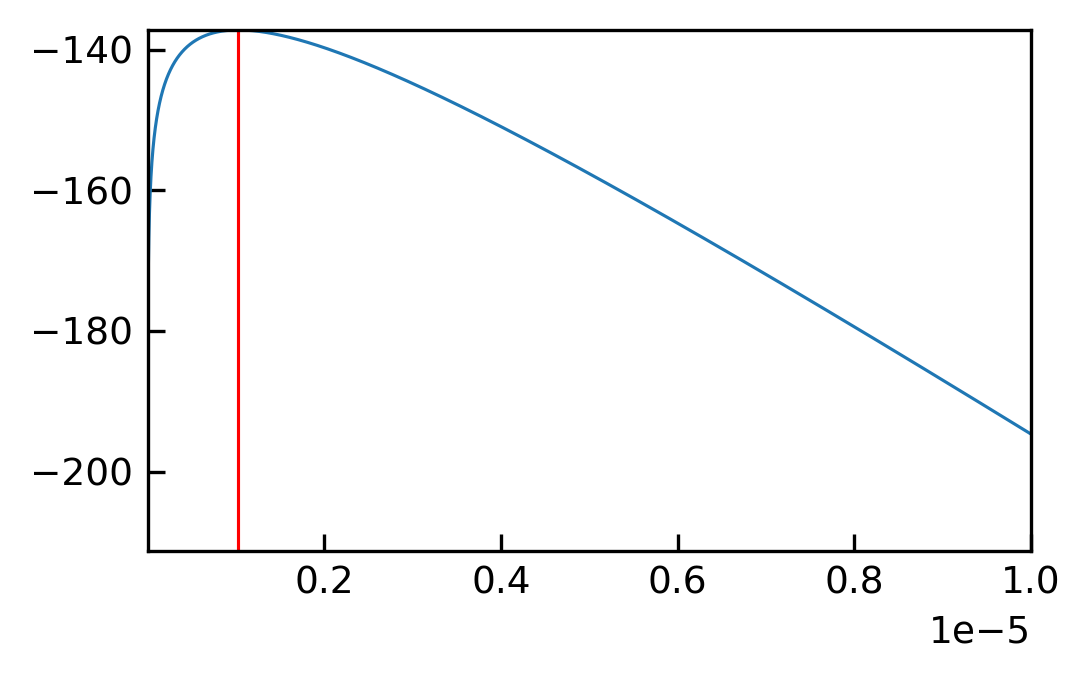

In [11]:
plt.plot(flux_resample.maxlike.alpha, flux_resample.maxlike.best_alpha['lev_s'])
plt.axvline(flux_resample.maxlike.best_alpha['alpha_s'], color='red')